## Multi-grain indexation based on diagram simulation and matching-rate.

In [1]:
import functools
import math
import random
import timeit

from tqdm.autonotebook import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from laueimproc.geometry import *

/tmp/ipykernel_38240/2367132554.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Reference constants and parameters
* `LATTICE` is the 3x2 matrix of the lattice parameter $[[a, b, c], [\alpha, \beta, \gamma]]$
* `PONI` are the detector parameters $[dist, poni_1, poni_2, rot_1, rot_2, rot_3]$

The incoming $ui$ ray is always $[0, 0, 1]$, according to the pyfai convention.

In [2]:
LATTICE = torch.tensor([3.6e-10, 3.6e-10, 3.6e-10, torch.pi/2, torch.pi/2, torch.pi/2])  # copper
PONI = torch.tensor([0.07, 73.4e-3, 73.4e-3, 0.0, -torch.pi/2, 0.0])  # mode laue detector on top
DETECTOR = {"shape": (2018, 2016), "pxl": 73.4e-6}  # shape is along d1 then d2

In [3]:
EV = 1.60e-19  # 1 eV = EV J
RAD = math.pi / 180.0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Associate the functions
* `laueimproc` provides atomic function to juggle with Bragg diffraction. It is your own stuff to compose them.
* Have a look on the `diffraction` tab of the api documentation.

In [4]:
def lattice_to_reciprocal(lattice):
    primitive = lattice_to_primitive(lattice)
    reciprocal = primitive_to_reciprocal(primitive)
    return reciprocal

def hkl_reciprocal_rot_to_uq(hkl, reciprocal, rot):
    reciprocal_rotated = rotate_crystal(reciprocal, rot)
    u_q = hkl_reciprocal_to_uq(hkl, reciprocal_rotated)
    return u_q
    
def uq_poni_to_detector(u_q, poni):
    u_f = uq_to_uf(u_q)
    point, dist = ray_to_detector(u_f, poni)
    point = point[dist > 0, :]  # ray wrong direction => virtual intersection
    point = point[point[..., 0] > 0, :]  # out of detector top
    point = point[point[..., 0] < DETECTOR["shape"][0] * DETECTOR["pxl"], :]  # out of detector bottom
    point = point[point[..., 1] > 0, :]  # out of detector left
    point = point[point[..., 1] < DETECTOR["shape"][1] * DETECTOR["pxl"], :]  # out of detector right
    return point

def detector_poni_to_uq(point, poni):
    u_f = detector_to_ray(point, poni)
    u_q = uf_to_uq(u_f)
    return u_q

In [5]:
def full_simulation(hkl, lattice, rot, poni):
    reciprocal = lattice_to_reciprocal(lattice)
    u_q = hkl_reciprocal_rot_to_uq(hkl, reciprocal, rot)
    point = uq_poni_to_detector(u_q, poni)
    return point

#### Timing comparison

In [6]:
# simple timing

BATCH = 100  # number of simulated diagrams
ROT = torch.eye(3)

hkl = select_hkl(LATTICE, e_max=25e3*EV, keep_harmonics=False)

# case float64
lattice, rot, poni = LATTICE.clone().to(torch.float64), ROT.clone().to(torch.float64), PONI.clone().to(torch.float64)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=BATCH)) / BATCH
print(f"float64: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32
lattice, rot, poni = LATTICE.clone().to(torch.float32), ROT.clone().to(torch.float32), PONI.clone().to(torch.float32)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=BATCH)) / BATCH
print(f"float32: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float64 batched
lattice, rot, poni = LATTICE.clone().to(torch.float64), ROT.clone().to(torch.float64), PONI.clone().to(torch.float64)
lattice = lattice[None, :].expand(BATCH, -1)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float64 batched: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32 batched
lattice, rot, poni = LATTICE.clone().to(torch.float32), ROT.clone().to(torch.float32), PONI.clone().to(torch.float32)
lattice = lattice[None, :].expand(BATCH, -1)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float32 batched: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float64 batched compiled
lattice, rot, poni = LATTICE.clone().to(torch.float64), ROT.clone().to(torch.float64), PONI.clone().to(torch.float64)
lattice = lattice[None, :].expand(BATCH, -1)
full_simulation_comp = torch.compile(full_simulation, dynamic=False)
speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float64 batched compiled: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32 batched compiled
lattice, rot, poni = LATTICE.clone().to(torch.float32), ROT.clone().to(torch.float32), PONI.clone().to(torch.float32)
lattice = lattice[None, :].expand(BATCH, -1)
full_simulation_comp = torch.compile(full_simulation, dynamic=False)
speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float32 batched compiled: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

if DEVICE.type == "cuda":
    # case float64 batched compiled gpu
    lattice, rot, poni = (
        LATTICE.clone().to(dtype=torch.float64, device=DEVICE),
        ROT.clone().to(dtype=torch.float64, device=DEVICE),
        PONI.clone().to(dtype=torch.float64, device=DEVICE),
    )
    lattice = lattice[None, :].expand(BATCH, -1)
    full_simulation_comp = torch.compile(full_simulation, dynamic=False)
    speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
    print(f"float64 batched compiled gpu: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")
    
    # case float32 batched compiled gpu
    lattice, rot, poni = (
        LATTICE.clone().to(dtype=torch.float32, device=DEVICE),
        ROT.clone().to(dtype=torch.float32, device=DEVICE),
        PONI.clone().to(dtype=torch.float32, device=DEVICE),
    )
    lattice = lattice[None, :].expand(BATCH, -1)
    full_simulation_comp = torch.compile(full_simulation, dynamic=False)
    speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
    print(f"float32 batched compiled gpu: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

float64: it takes 6268.23us by simulation <=> 159.53Hz
float32: it takes 5961.36us by simulation <=> 167.75Hz
float64 batched: it takes 1444.13us by simulation <=> 692.46Hz
float32 batched: it takes 1463.10us by simulation <=> 683.48Hz
float64 batched compiled: it takes 1443.68us by simulation <=> 692.67Hz
float32 batched compiled: it takes 1515.19us by simulation <=> 659.98Hz


### Simulate a diagram

#### Random draw single grain, no strain

In [7]:
# parameters of simulation
eps_a_ref = eps_b_ref = eps_c_ref = 0.0
eps_alpha_ref = eps_beta_ref = eps_gamma_ref = 0.0
lattice_ref = LATTICE.clone()
rot1_ref = 2.0 * math.pi * random.random()
rot2_ref = 2.0 * math.pi * random.random()
rot3_ref = 2.0 * math.pi * random.random()

#### Random draw single grain, with strain

In [8]:
# parameters of simulation
eps_a_ref = random.random() * 2e-2 - 1e-2  # eps_a = (a - a0) / a0
eps_b_ref = random.random() * 2e-2 - 1e-2
eps_c_ref = random.random() * 2e-2 - 1e-2
eps_alpha_ref = random.random() * 2e-3 - 1e-3  # eps_alpha = tan(alpha - alpha_0)
eps_beta_ref = random.random() * 2e-3 - 1e-3
eps_gamma_ref = random.random() * 2e-3 - 1e-3
lattice_ref = LATTICE.clone()
lattice_ref[0] *= 1.0 + eps_a_ref
lattice_ref[1] *= 1.0 + eps_b_ref
lattice_ref[2] *= 1.0 + eps_c_ref
lattice_ref[3] += eps_alpha_ref
lattice_ref[4] += eps_beta_ref
lattice_ref[5] += eps_gamma_ref
rot1_ref = 2.0 * math.pi * random.random()
rot2_ref = 2.0 * math.pi * random.random()
rot3_ref = 2.0 * math.pi * random.random()

#### Random draw multi grain, no strain

In [9]:
NB_GRAIN = 5

# parameters of simulation
eps_a_ref = eps_b_ref = eps_c_ref = 0.0
eps_alpha_ref = eps_beta_ref = eps_gamma_ref = 0.0
lattice_ref = LATTICE.clone()
rot1_ref = 2.0 * torch.pi * torch.rand(NB_GRAIN)
rot2_ref = 2.0 * torch.pi * torch.rand(NB_GRAIN)
rot3_ref = 2.0 * torch.pi * torch.rand(NB_GRAIN)

#### Random draw multi grain, with strain

In [10]:
NB_GRAIN = 5

# parameters of simulation
eps_a_ref = torch.rand(NB_GRAIN) * 2e-2 - 1e-2  # eps_a = (a - a0) / a0
eps_b_ref = torch.rand(NB_GRAIN) * 2e-2 - 1e-2
eps_c_ref = torch.rand(NB_GRAIN) * 2e-2 - 1e-2
eps_alpha_ref = torch.rand(NB_GRAIN) * 2e-3 - 1e-3  # eps_alpha = tan(alpha - alpha_0)
eps_beta_ref = torch.rand(NB_GRAIN) * 2e-3 - 1e-3
eps_gamma_ref = torch.rand(NB_GRAIN) * 2e-3 - 1e-3
lattice_ref = torch.cat([
    (LATTICE[0] * 1.0 + eps_a_ref).unsqueeze(1),
    (LATTICE[1] * 1.0 + eps_b_ref).unsqueeze(1),
    (LATTICE[2] * 1.0 + eps_c_ref).unsqueeze(1),
    (LATTICE[3] + eps_alpha_ref).unsqueeze(1),
    (LATTICE[4] + eps_beta_ref).unsqueeze(1),
    (LATTICE[5] + eps_gamma_ref).unsqueeze(1),
], dim=1)
rot1_ref = 2.0 * torch.pi * torch.rand(NB_GRAIN)
rot2_ref = 2.0 * torch.pi * torch.rand(NB_GRAIN)
rot3_ref = 2.0 * torch.pi * torch.rand(NB_GRAIN)

#### Simulation of the diagram

In [11]:
# parameters of simulation
PONI = torch.tensor([0.077, 73.4e-3, 73.4e-3, 0.0, -torch.pi/2, 0.0])  # mode laue detector on top
DETECTOR = {"shape": (2000, 2000), "pxl": 73.4e-6}  # shape is along d1 then d2
eps_a_ref = eps_b_ref = eps_c_ref = 0.0
eps_alpha_ref = eps_beta_ref = eps_gamma_ref = 0.0
lattice_ref = torch.tensor([4.0e-10, 3.6e-10, 3.2e-10, math.radians(50), math.radians(70), math.radians(110)])
rot1_ref = 0.0 * math.pi / 180
rot2_ref = 0.0 * math.pi / 180
rot3_ref = 0.0 * math.pi / 180

# cast into torch tensor
eps_a_ref = torch.asarray(eps_a_ref).reshape(-1)
eps_b_ref = torch.asarray(eps_b_ref).reshape(-1)
eps_c_ref = torch.asarray(eps_c_ref).reshape(-1)
eps_alpha_ref = torch.asarray(eps_alpha_ref).reshape(-1)
eps_beta_ref = torch.asarray(eps_beta_ref).reshape(-1)
eps_gamma_ref = torch.asarray(eps_gamma_ref).reshape(-1)

rot1_ref = torch.asarray(rot1_ref).reshape(-1)
rot2_ref = torch.asarray(rot2_ref).reshape(-1)
rot3_ref = torch.asarray(rot3_ref).reshape(-1)

lattice_ref = lattice_ref.reshape(-1, 6)

There are 228 experimental spots.
Lattice parameters:
   0 - a=4.000e-10, b=3.600e-10, c=3.200e-10, alpha=0.873, beta=1.222, gamma=1.920 
Rotations:
   0 - rot1=0.00, rot2=0.00, rot3=0.00


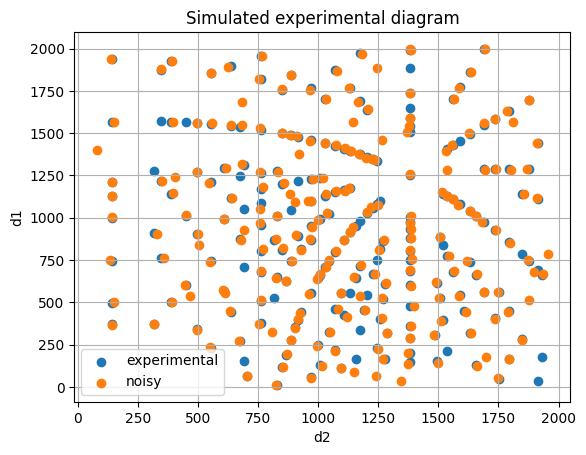

In [12]:
# simulation
rot_ref = angle_to_rot(rot1_ref, rot2_ref, rot3_ref, cartesian_product=False)
hkl = select_hkl(lattice_ref, e_max=25e3*EV, keep_harmonics=False)
if len(lattice_ref) != 1 and len(rot_ref) != 1:  # default behavour is cartesian product
    points = torch.cat([
        full_simulation(hkl, lattice_ref_, rot_ref_, PONI)
        for lattice_ref_, rot_ref_ in zip(lattice_ref, rot_ref)
    ])
else:
    points = full_simulation(hkl, lattice_ref, rot_ref, PONI)

# add experimental noise and false detection
points_exp = points + 5 * DETECTOR["pxl"] * torch.randn_like(points)
cond = torch.rand_like(points_exp) < 0.05  # proba to faild the detection
points_exp[cond[..., 0], 0] = torch.rand_like(points_exp[cond[..., 0], 0]) * DETECTOR["shape"][0] * DETECTOR["pxl"]
points_exp[cond[..., 1], 1] = torch.rand_like(points_exp[cond[..., 1], 1]) * DETECTOR["shape"][1] * DETECTOR["pxl"]

# print informations
print(f"There are {len(points)} experimental spots.")
print("Lattice parameters:")
for i, lat in enumerate(lattice_ref):
    print(
        f"   {i} - "
        f"a={lat[0]:.3e}, b={lat[1]:.3e}, c={lat[2]:.3e}, alpha={lat[3]:.3f}, beta={lat[4]:.3f}, gamma={lat[5]:.3f} "
    )
print("Rotations:")
for i, (r1, r2, r3) in enumerate(zip(rot1_ref, rot2_ref, rot3_ref)):
    print(
        f"   {i} - "
        f"rot1={r1:.2f}, rot2={r2:.2f}, rot3={r3:.2f}"
    )

# display in pyfai convention
plt.title("Simulated experimental diagram")
plt.xlabel("d2")
plt.ylabel("d1")
plt.scatter(*(points.flip(-1) / DETECTOR["pxl"]).movedim(-1, 0), label="experimental")
plt.scatter(*(points_exp.flip(-1) / DETECTOR["pxl"]).movedim(-1, 0), label="noisy")
plt.legend()
plt.grid()
plt.show()

### Indexation

#### Preparation
We work in the $u_q$ space, not in the detector space. First we have to transfere the points of the detector to the $u_q$ space.

In [13]:
# hyperparameters
ANGLE_RESOL = 0.6 * RAD
ANGLE_MAX_MATCHING = 0.4 * RAD
E_MAX = 20e3 * EV

# compute invariants parameters
all_rot = angle_to_rot(
    torch.arange(0, torch.pi / 2.0, ANGLE_RESOL),
    torch.arange(0, torch.pi / 2.0, ANGLE_RESOL),
    torch.arange(0, torch.pi / 2.0, ANGLE_RESOL),
).reshape(-1, 3, 3)
hkl = select_hkl(LATTICE, e_max=E_MAX, keep_harmonics=False)  # (d, 3)
uq_exp = detector_poni_to_uq(points_exp, PONI).movedim(0, -2).contiguous()  # (3, n)
reciprocal = lattice_to_reciprocal(LATTICE)  # (3, 3)

# compile functions
hkl_reciprocal_rot_to_uq_comp = torch.compile(hkl_reciprocal_rot_to_uq, fullgraph=True, dynamic=False)

#### Brute force indexation

In [14]:
# simulate
BATCH_SIZE = 1000

all_rate = torch.empty(*torch.broadcast_shapes(uq_exp.shape[:-2], all_rot.shape[:-2]))
for i in tqdm(range(0, len(all_rot), BATCH_SIZE), unit_scale=BATCH_SIZE):
    rot_batch = all_rot[i:i+BATCH_SIZE]
    uq_simul = hkl_reciprocal_rot_to_uq_comp(hkl, reciprocal, rot_batch)
    uq_simul = uq_simul.movedim(0, -2).contiguous()
    all_rate[i:i+BATCH_SIZE] = compute_matching_rate(uq_exp, uq_simul, phi_max=ANGLE_MAX_MATCHING)

  0%|          | 0/3375000 [00:00<?, ?it/s]

#### Selection and raffinement

38.0 <= rate <= 47.0


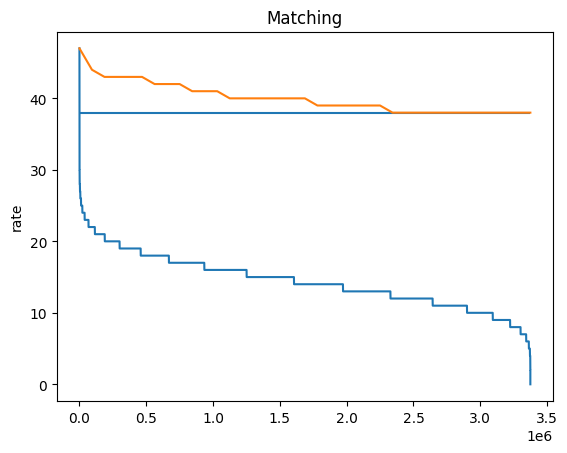

In [15]:
MIN_RATE = None  # or set int directely

sorted_rate_indices = torch.argsort(all_rate, descending=True)
min_rate = MIN_RATE or round(0.8 * float(all_rate[sorted_rate_indices[0]]))
rate_indices = sorted_rate_indices[:torch.argmin((all_rate[sorted_rate_indices] >= min_rate).view(torch.uint8))]

print(f"{all_rate[rate_indices[-1]]} <= rate <= {all_rate[rate_indices[0]]}")

plt.title("Matching")
plt.ylabel("rate")
plt.plot(all_rate[sorted_rate_indices])
plt.hlines(all_rate[rate_indices[-1]], 0, len(all_rate))
plt.plot(torch.linspace(0, len(all_rate), len(rate_indices)), all_rate[rate_indices])
plt.show()

In [17]:
# raffinement
rot1_init, rot2_init, rot3_init = rot_to_angle(all_rot[rate_indices])
lattice_init = LATTICE.unsqueeze(0).expand(len(rate_indices), -1)  # (n, 6)
rot1 = rot1_init.clone()
rot1.requires_grad = True
rot2 = rot2_init.clone()
rot2.requires_grad = True
rot3 = rot3_init.clone()
rot3.requires_grad = True
lattice = lattice_init.clone()
lattice.requires_grad = True

optim = torch.optim.Adam([rot1, rot2, rot3], lr=1e-8)
for _ in range(5):
    reciprocal = lattice_to_reciprocal(lattice[0])
    rot = angle_to_rot(rot1[0], rot2[0], rot3[0], cartesian_product=False)
    uq_simul = hkl_reciprocal_rot_to_uq_comp(hkl, reciprocal, rot)
    uq_simul = uq_simul.movedim(0, -2).contiguous()
    rate = compute_matching_rate_continuous(uq_exp, uq_simul, phi_max=ANGLE_MAX_MATCHING)
    print("rate", rate)

    loss = -rate
    optim.zero_grad()
    loss.backward()
    print(rot1.grad[0])
    # print(lattice.grad[0])
    optim.step()

rate tensor(31.1722, grad_fn=<ViewBackward0>)
tensor(294.8405)
rate tensor(31.1722, grad_fn=<ViewBackward0>)
tensor(294.8405)
rate tensor(31.1722, grad_fn=<ViewBackward0>)
tensor(294.8405)
rate tensor(31.1722, grad_fn=<ViewBackward0>)
tensor(294.8405)
rate tensor(31.1722, grad_fn=<ViewBackward0>)
tensor(294.8405)


#### Visualisation

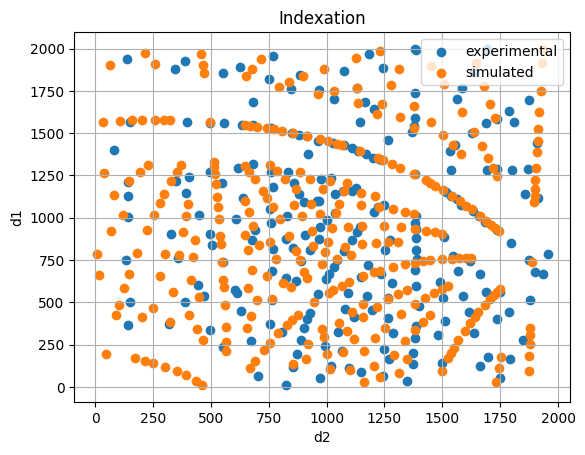

In [18]:
points_simul = full_simulation(hkl, LATTICE, all_rot[rate_indices[0]], PONI)

# display in pyfai convention
plt.title("Indexation")
plt.xlabel("d2")
plt.ylabel("d1")
plt.scatter(*(points_exp.flip(-1) / DETECTOR["pxl"]).movedim(-1, 0), label="experimental")
plt.scatter(*(points_simul.flip(-1) / DETECTOR["pxl"]).movedim(-1, 0), label="simulated")
plt.legend()
plt.grid()
plt.show()